In [1]:
from sklearn.datasets import load_digits
from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
import matplotlib.pyplot as plt

### 1.1

In [2]:
digits = load_digits()

In [3]:
print(digits.keys())

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])


In [4]:
data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

In [5]:
print(target)

[0 1 2 ... 8 9 8]


In [6]:
target_array = np.array(target)
three_indices = np.where(target_array == 3)
three_index = three_indices[0][0]
three_image = images[three_index]

In [7]:
img = np.array(three_image)

In [8]:
assert 2 == len(img.shape)

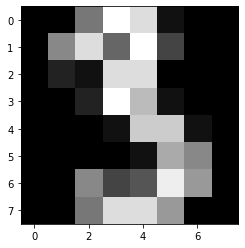

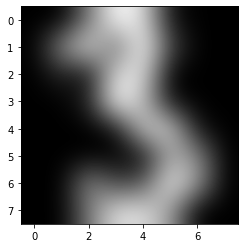

In [9]:
plt.figure()
plt.gray()
plt.imshow(img, interpolation="nearest")
plt.show()
plt.imshow(img, interpolation="bicubic")
plt.show()

In [10]:
X_all = data
y_all = target
X_train, X_test, y_train, y_test = model_selection.train_test_split(digits.data, digits.target, test_size = 0.4, random_state = 0)

### 1.2

In [11]:
def dist_loop(training, test):
    # training is N x D matrix
    N, D = training.shape
    # test is M x D matrix
    M, D2 = test.shape

    assert D == D2, "pixel vectors must have same length"
    
    def euclid(x1, x2):
        return np.sqrt(np.sum(np.square(x1-x2)))

    result = np.empty([N, M])
    for n in range(N):
        train_element = training[n]
        for m in range(M):
            test_elem = test[m]

            result[n][m] = euclid(train_element, test_elem)

    return result

<span style="color:green;font-weight:bold">

Very similar to sample solution.

</span>

### 1.3

In [12]:
def dist_vec(training, test):
    squared_diff = np.square(training[:,None] - test)
    sum_diffs = np.sum(squared_diff, axis=2)
    result = np.sqrt(sum_diffs)
    return result

<span style="color:green;font-weight:bold">

Sample solution specified training[:,None,:] - test[None,:,:] more explicitly

</span>

<span style="color:green;font-weight:bold">



</span>

In [13]:
def dist_partial_vec(training, test):
    # training is N x D matrix
    N, D = training.shape
    # test is M x D matrix
    M, D = test.shape

    result = np.empty([N, M])
    for n in range(N):
        train_element = training[n]
        result[n] = np.sqrt(np.sum(np.square(test - train_element)))

    return result

Because of unnecessary allocations the pure vectorized version is actually slower than just vectorizing the inner loop 

In [14]:
#%timeit dist_loop(X_train, X_test)

In [15]:
#%timeit dist_vec(X_train, X_test)

In [16]:
#%timeit dist_partial_vec(X_train, X_test)

In [17]:
res1 = dist_loop(X_train, X_test)
res2 = dist_vec(X_train, X_test)

assert np.all(res1 == res2)

### 1.4

In [18]:
def count_votes(votes):
    """Given an array of votes returns the number with the most votes"""
    return np.bincount(votes).argmax()


def k_nearest_neighbor(xtrain, ytrain, xtest, k):
    """Finds a prediction for samples xtest based on the nearest k xtrain and their labels ytrain."""
    distances = dist_vec(xtrain, xtest)
    k_nearest_index = np.argpartition(distances, k, axis=0)[:k, :]
    votes = ytrain[k_nearest_index]
    
    predictions = np.apply_along_axis(count_votes, axis=0, arr=votes)
    
    return predictions

<span style="color:green;font-weight:bold">

Also very similar to sample solution.

</span>

In [19]:
def error(predictions, labels):
    assert len(predictions) == len(labels), "labels and predictions must have same length"
    
    wrong_predictions = sum(predictions != labels)
    return wrong_predictions / len(labels)

In [20]:
X_train_filtered = X_train[np.isin(y_train, [3,9])]
y_train_filtered = y_train[np.isin(y_train, [3,9])]

X_test_filtered = X_test[np.isin(y_test, [3,9])]
y_test_filtered = y_test[np.isin(y_test, [3,9])]

ks = [1, 3, 5, 9, 17, 33]
predictions = [k_nearest_neighbor(X_train_filtered, y_train_filtered, X_test_filtered, k)
                   for k in ks]
errors = ["{:.4f}%".format(100 * error(prediction, y_test_filtered)) for prediction in predictions] 
print(errors)

['1.3889%', '0.6944%', '0.6944%', '0.6944%', '0.6944%', '2.0833%']


When at least k=3 neighbors are chosen, the performance stays the same until an upper bound which is k=17 in this case.

### 2

In [21]:
def split_folds(data, labels, L):
    assert len(data) == len(labels), "lables and data must have same length"

    shuffled_indicies = np.random.permutation(len(data))
    
    # shuffle both data and labels with same index
    data = data[shuffled_indicies]
    labels = labels[shuffled_indicies]
    
    X_folds = np.array_split(data, L)
    y_folds = np.array_split(labels, L)
    
    return X_folds, y_folds

<span style="color:green;font-weight:bold">

Also very similar to sample solution.

</span>

In [22]:
def kth_test_data(data, k):
    """Returns (kth element, list without kth element)"""
    return data[k], np.concatenate(data[:k] + data[k+1:])


def test_classifier(X, y, L, k):
    X_folds, y_folds = split_folds(X, y, L)
    
    our_error = []
    scikit_error = []
    
    for i in range(len(X_folds)):
        X_test, X_train = kth_test_data(X_folds, i)
        y_test, y_train = kth_test_data(y_folds, i)
                
        predictions = k_nearest_neighbor(X_train, y_train, X_test, k)
        our_error.append(error(predictions, y_test))
        
        sk_classifier = KNeighborsClassifier(n_neighbors=k)     # missed "n_neighbors=k" in our original solution
        sk_classifier.fit(X_train, y_train)
        sk_predictions = sk_classifier.predict(X_test)
        
        scikit_error.append(error(sk_predictions, y_test))
    
    
    return ((np.mean(our_error),np.std(our_error)), (np.mean(scikit_error), np.std(scikit_error)))

for k in [1, 5]:
    print(f"k = {k}")
    
    for L in [2 ,5, 10]:
        print(f"\tL = {L}")
        
        (our_err, our_std), (sk_err, sk_std) = test_classifier(X_all, y_all, L, k) 
        print(f"\t\tour error:    {100* our_err:.8f}%,\t our standard deviation:    {100 * our_std:.8f}%")
        print(f"\t\tscikit error: {100* sk_err:.8f}%, \t scikit standard deviation: {100 * sk_std:.8f}%")

k = 1
	L = 2
		our error:    1.28012813%,	 our standard deviation:    0.39025049%
		scikit error: 1.28012813%, 	 scikit standard deviation: 0.39025049%
	L = 5
		our error:    1.33503559%,	 our standard deviation:    0.88619904%
		scikit error: 1.33503559%, 	 scikit standard deviation: 0.88619904%
	L = 10
		our error:    1.27963998%,	 our standard deviation:    0.86249994%
		scikit error: 1.27963998%, 	 scikit standard deviation: 0.86249994%
k = 5
	L = 2
		our error:    2.00402080%,	 our standard deviation:    1.22537786%
		scikit error: 2.00402080%, 	 scikit standard deviation: 1.22537786%
	L = 5
		our error:    1.44738471%,	 our standard deviation:    0.66925970%
		scikit error: 1.44738471%, 	 scikit standard deviation: 0.66925970%
	L = 10
		our error:    1.28088144%,	 our standard deviation:    0.61535074%
		scikit error: 1.28088144%, 	 scikit standard deviation: 0.61535074%


<span style="color:green;font-weight:bold">

"n_neighbors=k" paramter not passed to KNeighborsClassifier constructor => scikit error rates are now identical to those of our solution.

</span>

#### Observations

- The scitkit classifier seems to be using a k around 5 since the results are identical when we choose k=5

- the error gets smaller for bigger L, since this means a smaller portion of the data is used for testing which in turn means a bigger training set